Tutorial: Computing with large datasets
=======================================
The Gromov-Wasserstein distance between two cells with 100 points takes about 9ms to compute on a standard desktop. The number of pairs grows quadratically with the number of cells, and so the total runtime can become large.

For large datasets we provide two tools to reduce the necessary computation, as well as a hybrid of these.

In <a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) the author establishes several lower bounds for the Gromov-Wasserstein distance. We have implemented one of the fastest, SLB. <a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2). For the purposes of clustering analysis it may be enough to know the precise Gromov-Wasserstein distance only for cells which are close to each other in the morphology space, because most clustering algorithms are insensitive to the precise distance between points which are very far apart. Similarly, many dimensionality reduction techniques only respect local distances but do not preserve global structure of the space, and so it is not crucial to know the exact values between disparate cells.

In [2]:
import os
wd= os.path.join(os.getcwd(),"../../CAJAL/data")
icdm_file=os.path.join(wd,"swc_100pts_eu_4_17_2023.csv")
from cajal.run_gw import cell_iterator_csv
names, _ = zip(*cell_iterator_csv(icdm_file))
names=list(names)

In [1]:
from cajal.run_gw import slb_parallel
# num_processes can be set to the number of cores on your machine.
slb_parallel(
    icdm_file,
    num_processes =8,
    out_csv = os.path.join(wd,"slb_data.csv")
)
#slb_distance_matrix is a numpy array of shape (N,N), where N==len(names)

Computation finished. Computed 129286 cell pairs. Time elapsed: 0.14007997512817383


Although the SLB is only a lower bound for the Gromov-Wasserstein distance, using it alone is already fairly accurate as a classifier. We will recapitulate the same analysis done for the tutorial on predicting the molecular type of neurons.

In [4]:
import pandas
import numpy as np
metadata = pandas.read_csv(os.path.join(wd,"cell_types_specimen_details.csv"))
metadata.index = [str(m) for m in metadata["specimen__id"]]
metadata=metadata.loc[list(names)]
cre_lines = np.array(metadata["line_name"])

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
clf = KNeighborsClassifier(metric="precomputed", n_neighbors=10, weights="distance")
cv = StratifiedKFold(n_splits=7, shuffle=True)

In [ ]:
from cajal.utilities import read_gw_dists, dist_mat_of_dict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import matthews_corrcoef

_, slb_dist_dict = read_gw_dists(os.path.join(wd,"slb_data.csv"), header=True)
slb_dmat = dist_mat_of_dict(slb_dist_dict,cell_names=names)
mcc_slb=[]
for i in range(50):
        cvp = cross_val_predict(clf, X=slb_dmat, y=cre_lines, cv=cv)
        mcc_slb.append(matthews_corrcoef(cvp, cre_lines))

In [8]:
print(np.mean(mcc_slb))

0.22309533564728434


If the SLB2 distance between all cells are known, there is a straightforward algorithm<a name="cite_ref-3"></a>[<sup>[3]</sup>](#cite_note-3) to compute the $k$ nearest neighbors of any given cell under the Gromov-Wasserstein metric. If $k$ is chosen sufficiently large, this is enough to understand the local structure of the morphology space and cluster it.

If the SLB2 distance between all cells are known, there is a straightforward algorithm<a name="cite_ref-3"></a>[<sup>[3]</sup>](#cite_note-3) to compute the $k$ nearest neighbors of any given cell under the Gromov-Wasserstein metric. If $k$ is chosen sufficiently large, this is enough to understand the local structure of the morphology space and cluster it.

The second tool we provide is an implementation of the quantized Gromov-Wasserstein distance proposed by Chowdhury, Miller and Needham<a name="cite_ref-4"></a>[<sup>[4]</sup>](#cite_note-4). Given cells $X$ and $Y$, the quantized Gromov-Wasserstein distance is given as follows:
1. Partition the points of $X$ and $Y$ into $n$ clusters. Let $X^n, Y^n$ be the set of medoids of these clusters; $X^n$ can be thought of as the best possible approximation to $X$ in the GW morphology space by a set with at most $n$ points.
2. Computing the optimal Gromov-Wasserstein transport plan between the subspaces $X^n$ and $Y^n$ formed by the medoids of each cluster.
3. Extend this to a global transport plan between $X$ and $Y$ by pairing points within paired clusters by their distance from the medoid, and compute the distortion associated to this transport plan.
This approximation gives an acceptable tradeoff between precision and computation time.

We combine these two tools in an integrated analysis method which allows the user to reduce computation time in three different ways.
1. by computing only the $k$ nearest neighbors of each cell, and estimating the rest roughly using SLB2
2. by accepting a small fraction of errors in the reported nearest neighbors list of each cell (i.e., 98% of the nearest neighbors are correct)
3. by using the quantized GW distance as a proxy for the true GW distance, which adds some noise to the reported distance between nearest neighbors

The routine below does the following. All cells in the given intracell distance matrix file have 100 points.
1. Compute the pairwise SLB between any two cells in the given list of intracell distance matrices.
2. For each cell $X$, identify the 30 estimated nearest neighbors $X_1,\dots, X_{30}$ based on the SLB distance matrix, and compute the QGW distance $QGW_{25}(X,X_k)$ for all 30 pairs.
3. For each remaining cell pair $X,Y$, we estimate the probability that $QGW_{25}(X,Y)$ is small enough to "injure" the existing purported list of nearest neighbors. We sort the cell pairs in descending order by this probability and compute the $QGW_{25}$ distance between pairs in this list until the expected number of "injuries" remaining is less than 5% of the nearest neighbor table, so that of the reported 30 nearest nearest neighbors to each point, 28.5 are expected to be correct.
4. For all remaining cells we estimate the correct distance based on the SLB.

In [7]:
import pandas
import numpy as np
metadata = pandas.read_csv(os.path.join(wd,"cell_types_specimen_details.csv"))
metadata.index = [str(m) for m in metadata["specimen__id"]]
metadata=metadata.loc[list(names)]
cre_lines = np.array(metadata["line_name"])

In [21]:
from cajal.run_gw import combined_slb_quantized_gw
from cajal.utilities import read_gw_dists, dist_mat_of_dict


In [11]:
import matplotlib.pyplot as plt
import statistics
from cajal.run_gw import combined_slb_quantized_gw
from cajal.utilities import dist_mat_of_dict,read_gw_dists
def test_at_clustering_resolution(n : int):
    combined_slb_quantized_gw(
        input_icdm_csv_location= icdm_file,
        gw_out_csv_location = os.path.join(wd,"qgw" + str(n) + "_estimates.csv"),
        num_processes = 20,
        num_clusters = n,
        accuracy = 1,
        nearest_neighbors = 10)

    _, qgw_dist_dict = read_gw_dists(os.path.join(wd,"qgw" + str(n) + "_estimates.csv"), header=False)
    qgw_dmat = dist_mat_of_dict(qgw_dist_dict,cell_names=names)
    mcc=[]
    cvp = cross_val_predict(clf, X=qgw_dmat, y=cre_lines, cv=cv)
    for i in range(50):
        cvp = cross_val_predict(clf, X=qgw_dmat, y=cre_lines, cv=cv)
        mcc.append(matthews_corrcoef(cvp, cre_lines))
    return mcc

In [ ]:
mcc100=test_at_clustering_resolution(100)

(array([6., 8., 3., 5., 6., 7., 9., 2., 1., 3.]),
 array([0.21182139, 0.2161362 , 0.220451  , 0.2247658 , 0.2290806 ,
        0.23339541, 0.23771021, 0.24202501, 0.24633981, 0.25065461,
        0.25496942]),
 <BarContainer object of 10 artists>)

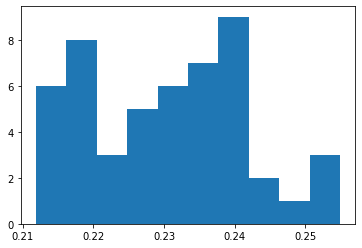

In [13]:
plt.hist(mcc100)

In [15]:
np.mean(mcc100)

0.23048577366808565

(array([ 1.,  2.,  3.,  8., 12.,  9., 11.,  2.,  0.,  2.]),
 array([0.19723913, 0.20216032, 0.20708151, 0.21200271, 0.2169239 ,
        0.22184509, 0.22676629, 0.23168748, 0.23660867, 0.24152987,
        0.24645106]),
 <BarContainer object of 10 artists>)

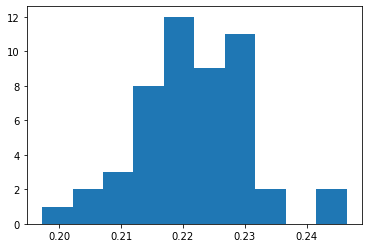

In [92]:
plt.hist(mcc_slb)

In [16]:
np.mean(mcc_slb)

0.22309533564728434

In [ ]:
mcc20=test_at_clustering_resolution(20)

In [94]:
print(statistics.mean(mcc_slb))
print(statistics.stdev(mcc_slb))

0.22151490467785648
0.008957719842506286


In [86]:
print(statistics.mean(mcc20))
print(statistics.stdev(mcc20))

0.2160224374690422
0.010191307459348296


<a name="cite_note-1"></a>1.[^](#cite_ref-1) Mémoli, F. P. [Gromov–Wasserstein Distances and the Metric Approach to Object Matching.](https://dblp.uni-trier.de/db/journals/focm/focm11.html#Memoli11) Found Comput Math (2011) 11, 417–487.

<a name="cite_note-2"></a>2.[^](#cite_ref-2) Specifically we have implemented the expression which appears on the right hand side of the first inequality of Corollary 6.2 on page 462, for p = 2. This expression is not directly named in the paper. We do not compute the quantity Mémoli calls SLB, as it is too computationally expensive for our purposes.

<a name="cite_note-3"></a>3.[^](#cite_ref-3) A simple algorithm for computing the nearest neighbors of a cell in the Gromov-Wasserstein morphology space if the SLB2 distance is known is as follows:
1. First, sort all other cells by their SLB2 distance from $c_0$, as $c_1, c_2, c_3,\dots$.
2. Next, compute the Gromov-Wasserstein distance $GW(c_0,c_j)$, as $j = 1, 2, 3,\dots$. Write $e^k_j$ for the $k$-th element of the set $GW(c_0,c_1),GW(c_0,c_2),\dots,GW(c_0,c_j)$ when these are ordered from least to greatest. ($e^k_j$ is only defined when $k \leq j$). Continue computing $GW(c_0,c_j)$ until $j$ reaches a value $\ell$ such that for all $i> \ell$, $SLB(c_0,c_i) > e^k_\ell$. Because SLB is a lower bound, at this point, the $k$ nearest neighbors of $c_0$ are contained in the set $\{c_1,\dots, c_\ell\}$.

<a name="cite_note-4"></a>4.[^](#cite_ref-4) Chowdhury, S., Miller, D., Needham, T. (2021). Quantized Gromov-Wasserstein. In: Oliver, N., Pérez-Cruz, F., Kramer, S., Read, J., Lozano, J.A. (eds) Machine Learning and Knowledge Discovery in Databases. Research Track. ECML PKDD 2021. Lecture Notes in Computer Science(), vol 12977. Springer, Cham. https://doi.org/10.1007/978-3-030-86523-8_49



contribute to the neuronal plasticity in the C. elegans. This example utilizes a dataset consisting of 799 3D neuronal reconstructions of the C.elegans DVB neuron across various mutant and control strains during days 1 to 5 of adulthood. The dataset can be downloaded from the following
[folder](https://www.dropbox.com/scl/fo/y7axeardkwyn1d6j97dqr/h?dl=0&rlkey=4b65w4tc93e778rql72d275ym). The DVB neuron is an excitatory GABAergic motor
interneuron located in the dorso-rectal ganglion of the worm, and is known to undergo post-developmental neurite outgrowth in males. This outgrowth 
alters the neuron's morphology and synaptic connectivity, contributing to
changes in the spicule protraction step of male mating behavior. More information about this 
dataset can be found at:

\- Hart, M. P. & Hobert, O. [Neurexin controls plasticity of a mature, sexually dimorphic neuron.](https://www.nature.com/articles/nature25192) Nature 553, 165-170, (2018).

\- Govek, K. W. et al. [Analysis and integration of single-cell morphological data using metric geometry.](https://www.biorxiv.org/content/10.1101/2022.05.19.492525v3) (2022). DOI: 10.1101/2022.05.19.492525 (bioRxiv).

To begin our analysis, we calculate the Gromov-Wasserstein distance between each pair of cells. For the sake of time, here we just sample 50 points per cell. This computation typically requires 20-30 minutes to complete on a standard desktop computer. A larger number of sampled points would offer better results, but would also increase the computing time.